In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as spo
import scipy.stats as sts
plt.style.use('seaborn')

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## New HDF5 Data Import
The long waiting time has been relegated to a different notebook, and now this notebook imports the clean data directly from an HDF5 file.

In [3]:
run_label = '2020_11_09' ## Change this to look at different runs
hdf_name = '{}_clean_data.h5'.format(run_label)

In [4]:
gases = ['H2', 'H2O', 'N2', 'O2', 'CO2']
gas_tables = [] # appendable list of gas data tables from HDF5

for gas in gases:
    gas_tables.append(pd.read_hdf(hdf_name, key=gas))

### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [5]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [6]:
#O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [7]:
jump_bounds = [[51000, 64600],[64400, 89500],[90000, 110200],[110200, 150000]]
init_params = [7, 5900, 800]

In [8]:
def jump_analysis(data_table, bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = data_table[data_table['exp_time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['exp_time'].unique()[0]
    jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
    time_temp_vals = jump_table[['jump_time', 'temp_est']].T.to_numpy()
    fit_jump = jump_table['pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['exp_time'], jump_table['CO2_Pressure'], jump_fits, popt, pcov, time_temp_vals

In [9]:
def alt_jump_analysis(data_table, bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = data_table[data_table['exp_time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['exp_time'].unique()[0]
    jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
    time_temp_vals = jump_table[['jump_time', 'ch1_lerp']].T.to_numpy()
    fit_jump = jump_table['pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['exp_time'], jump_table['pressure'], jump_fits, popt, pcov, time_temp_vals

In [10]:
alt_jump_outs = []
# Warnings incoming. Not a problem
for idx, gas in enumerate(gases):
    gas_jumps = []
    for listed_jump in jump_bounds:
        gas_jump_out = alt_jump_analysis(gas_tables[idx], listed_jump, init_params)
        gas_jumps.append(gas_jump_out)
    alt_jump_outs.append(gas_jumps)

/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

The code from the above cell creates a 3-layer nested list.
- First index: which gas
- Second index: which jump
- Third index: times, pressures, fit pressures, fitted parameter values, covariance matrix, time-and-temperature table

In [11]:
# Sample output: the popt values from CO2 jump 1
alt_jump_outs[4][0][3]

array([6.86386181e-05, 1.89812147e+03, 5.34528993e-03])

### Plotting

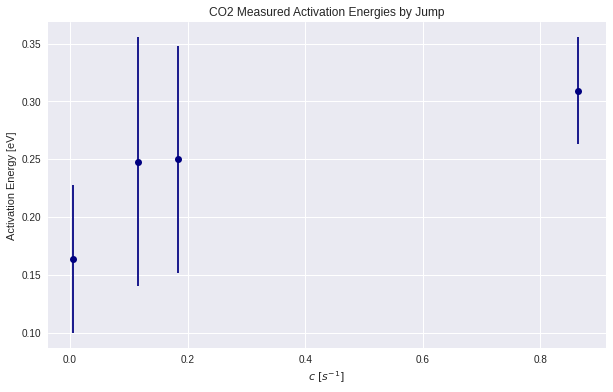

In [12]:
CO2_Ea_vals = np.array([alt_jump_outs[4][0][3][1], alt_jump_outs[4][1][3][1], alt_jump_outs[4][2][3][1], alt_jump_outs[4][3][3][1]])
CO2_Ea_errs = np.array([alt_jump_outs[4][0][4][1][1], alt_jump_outs[4][1][4][1][1], alt_jump_outs[4][2][4][1][1], alt_jump_outs[4][3][4][1][1]])
CO2_D_vals = np.array([alt_jump_outs[4][0][3][2], alt_jump_outs[4][1][3][2], alt_jump_outs[4][2][3][2], alt_jump_outs[4][3][3][2]])
CO2_D_errs = np.array([alt_jump_outs[4][0][4][2][2], alt_jump_outs[4][1][4][2][2], alt_jump_outs[4][2][4][2][2], alt_jump_outs[4][3][4][2][2]])

k_B = 8.617e-5 # Boltzmann constant in eV/K

fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(CO2_D_vals, CO2_Ea_vals*k_B, yerr=CO2_Ea_errs*k_B, xerr=CO2_D_errs, fmt='o', color='navy')

ax.set_title('CO2 Measured Activation Energies by Jump')
ax.set_xlabel('$c$ $\\left[s^{-1}\\right]$')
ax.set_ylabel('Activation Energy [eV]')

fig.savefig('images/co2_Ea_vals_2020_11_09.png', dpi=144)
plt.show()

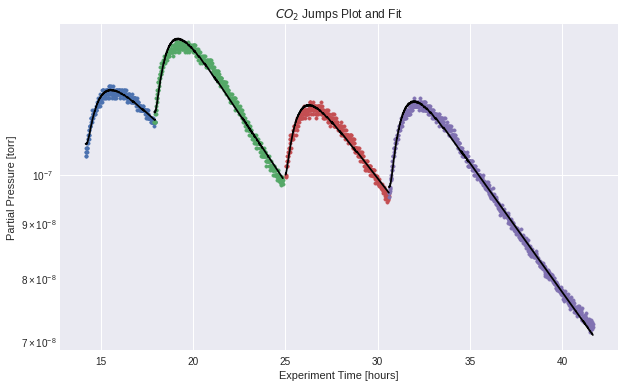

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(4):
    ax.scatter(alt_jump_outs[4][i][0]/3600, alt_jump_outs[4][i][1], marker='.')
    ax.plot(alt_jump_outs[4][i][0]/3600, alt_jump_outs[4][i][2], color='black')

#for idx, guess in enumerate(CO2_Ea_guesses):
#    ax.plot(CO2_jump4_alt[0]/3600, CO2_jump4_guessfits[idx], label='Ea = {}'.format(guess))
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$CO_2$ Jumps Plot and Fit')
#ax.legend()
ax.set_yscale('log')
fig.savefig('images/co2_all_fits_2020_11_09.png', dpi=144)

plt.show()

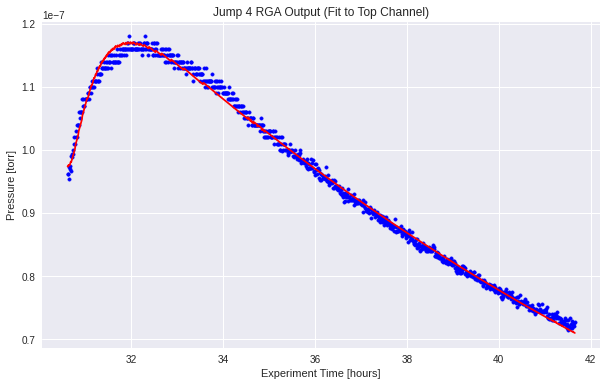

In [14]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1], marker='.', color='blue', label='RGA Output')
ax1.plot(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][2], color='red', label='RGA Fit')

ax1.set_title('Jump 4 RGA Output (Fit to Top Channel)')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
#ax1.set_yscale('log')

plt.savefig('images/co2_4_alt_2020_11_09.png', dpi=144)

plt.show()

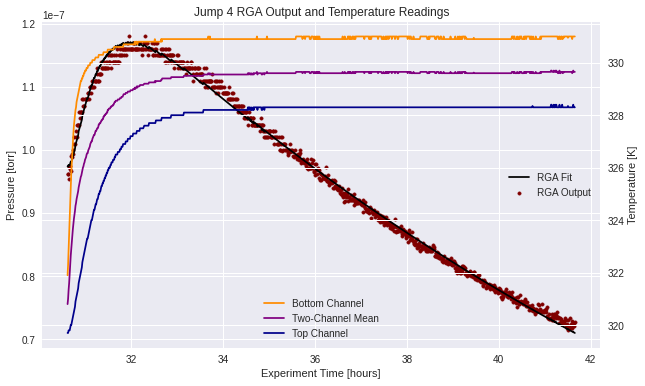

In [15]:
jump4_temps = gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[3][0], jump_bounds[3][1])][['ch1_lerp', 'ch2_lerp', 'mean_temp']]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1], marker='.', color='maroon', label='RGA Output')
ax1.plot(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][2], color='black', label='RGA Fit')

ax2 = ax1.twinx()

ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['ch2_lerp'], color='darkorange', label='Bottom Channel')
ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['mean_temp'], color='purple', label='Two-Channel Mean')
ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['ch1_lerp'], color='darkblue', label='Top Channel')

ax1.set_title('Jump 4 RGA Output and Temperature Readings')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
ax1.legend(loc='right')

ax2.set_ylabel('Temperature [K]')
ax2.legend(loc='lower center')

plt.savefig('images/co2_4_fit_2020_11_09.png', dpi=144)
plt.show()

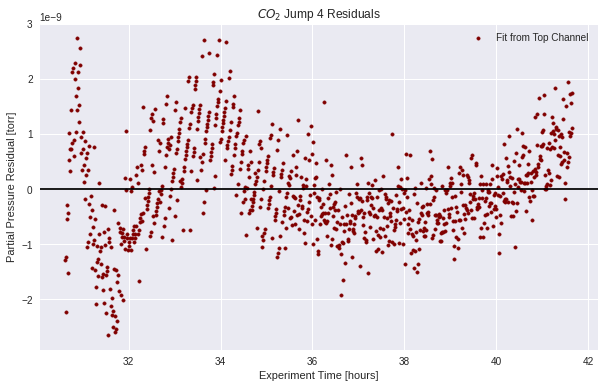

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1] - alt_jump_outs[4][3][2], marker='.', color='maroon', label='Fit from Top Channel')
ax.set_ylabel('Partial Pressure Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.axhline(color='k')
ax.set_title('$CO_2$ Jump 4 Residuals')
ax.legend()

fig.savefig('images/co2_4_resid_2020_11_09.png', dpi=144)

plt.show()

In [17]:
#CO2_data['Pressure'].iloc[np.array(CO2_times.between(50000,110000))]

### Finding the Bounds of Each Jump

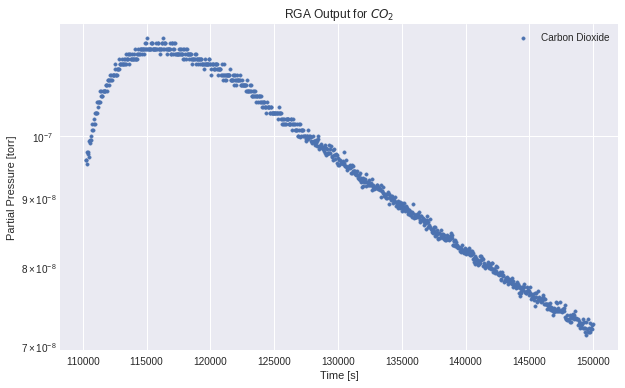

In [18]:
bnds = [110200, 150000]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(gas_tables[4]['exp_time'].iloc[np.array(gas_tables[4]['exp_time'].between(bnds[0],bnds[1]))],
           gas_tables[4]['pressure'].iloc[np.array(gas_tables[4]['exp_time'].between(bnds[0],bnds[1]))], marker='.', label='Carbon Dioxide')
ax.set_title('RGA Output for $CO_2$')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Partial Pressure [torr]')
ax.legend()
ax.set_yscale('log')

plt.show()

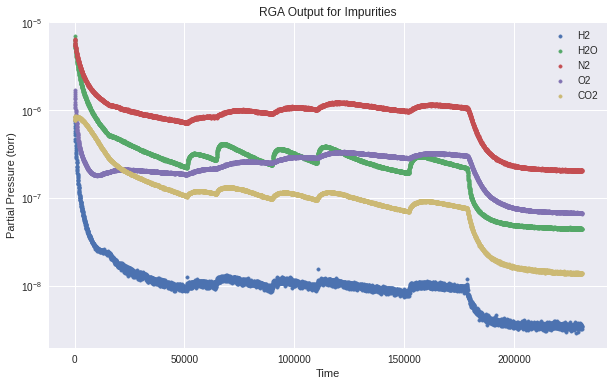

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

for idx, gas in enumerate(gases):
    ax.scatter(gas_tables[idx]['exp_time'], gas_tables[idx]['pressure'], marker='.', label=gas)

ax.set_title('RGA Output for Impurities')
ax.set_xlabel('Time')
ax.set_ylabel('Partial Pressure (torr)')
ax.legend()
ax.set_yscale('log')

#ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
#ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
#ax[1].set_title('Temperature over Time from Top and Bottom Channels')
#ax[1].set_xlabel('Time [sec]')
#ax[1].set_ylabel('Temperature (C)')
#ax[1].legend()

fig.savefig('plot_out_{}.png'.format(run_label), dpi=300)
plt.show()

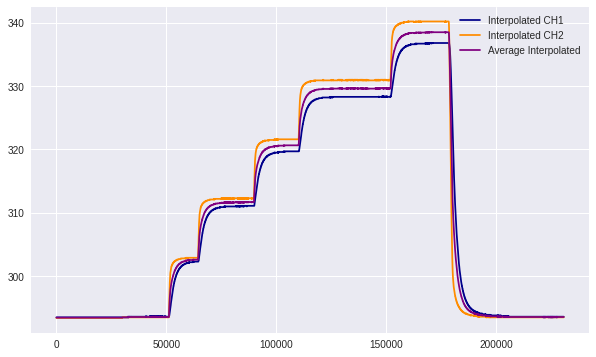

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['ch1_lerp'], label='Interpolated CH1', color='darkblue')
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['ch2_lerp'], label='Interpolated CH2', color='darkorange')
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['mean_temp'], label='Average Interpolated', color='purple')
ax.legend()

plt.show()

In [21]:
#IO.RemoveZipDir()